# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
from urllib.request import urlretrieve

import numpy as np
from scipy.spatial.distance import cdist

In [2]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [18]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        try :
            return self.embeddings[self.word2id[word]]
        except KeyError:
            # print("'{}' not in vocabulary".format(word))
            return np.zeros(self.embeddings.shape[1])
        # raise NotImplementedError('Fill in the blank')
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        e1 = self.encode(word1)
        e2 = self.encode(word2)
        return np.dot(e1,e2)/np.linalg.norm(e1)/np.linalg.norm(e2)
        # raise NotImplementedError('Fill in the blank')
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort
        emb = self.encode(word).reshape(1,-1)
        dist = cdist(emb, self.embeddings, "cosine").squeeze()
        best_id = np.argsort(dist)[:k]
        words = [self.id2word[idx] for idx in best_id]
        return words
        # raise NotImplementedError('Fill in the blank')

In [19]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.2644975466165475
cat dog 0.7078641298542563
cat pet 0.675331335997638
Paris France 0.6892958925806543
Paris Germany 0.4051242286737548
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348005
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'pup', 'canine']
['dogs', 'dog', 'cats', 'puppies', 'Dogs']
['Paris', 'France', 'Parisian', 'Marseille', 'Brussels']
['Germany', 'Austria', 'Europe', 'Berlin', 'Hamburg']


In [20]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        n_sentences = len(sentences)
        n_words = len(self.word2vec.words)
        n_doc = np.zeros(n_words)
        for s in sentences:
            words = [w for w in s.split(" ") if len(w) > 0]
            for w in list(set(words)):
                try:
                    n_doc[self.word2vec.word2id[w]] += 1
                except KeyError:
                    pass
        
        idf = np.log(n_sentences/(n_doc+1e-10))
        idf = {self.word2vec.id2word[idx] : idf[idx] for idx in range(n_words)}
        return idf
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        words = [w for w in sentence.split(" ") if len(w) > 0]
        word_emb = np.array(list(map(self.word2vec.encode, words)))
        if idf is None:
            # mean of word vectors
            return np.mean(word_emb, axis=0)
            # raise NotImplementedError('Fill in the blank')
        else:
            # idf-weighted mean of word vectors
            word_idf = []
            for word in words:
                try:
                    word_idf.append(idf[word])
                except KeyError:
                    word_idf.append(0)
            return np.average(word_emb, axis=0, weights=word_idf)
            # raise NotImplementedError('Fill in the blank')

    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm
        e1 = self.encode(sentence1, idf)
        e2 = self.encode(sentence2, idf)
        return np.dot(e1,e2)/np.linalg.norm(e1)/np.linalg.norm(e2)
        # raise NotImplementedError('Fill in the blank')
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        query = self.encode(sentence, idf).reshape(1,-1)
        keys = np.vstack([self.encode(sentence, idf) for sentence in sentences])
        dist = cdist(query, keys, "cosine").squeeze()
        best_id = np.argsort(dist)[:k]
        return [sentences[idx] for idx in best_id]        
        # raise NotImplementedError('Fill in the blank')

In [21]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=100000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, s in enumerate(similar_sentences):
    print(str(i+1) + ')', s)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, s in enumerate(similar_sentences):
    print(str(i+1) + ')', s)

Loaded 100000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7065220648251475
1 smiling african american boy . 
1) 1 smiling african american boy . 
2) 2 woman dancing while pointing . 
3) 5 women and 1 man are smiling for the camera . 
4) a small boy following 4 geese . 
5) 2 female babies eating chips . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6400799939346448
1 smiling african american boy . 
1) 1 smiling african american boy . 
2) 1 man singing and 1 man playing a saxophone in a concert . 
3) two women and 1 man walking across the street . 
4) 3 males and 1 woman enjoying a sporting event 
5) 5 women and 1 man are smiling for the camera . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [22]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        word_in_common = [w for w in self.fr_word2vec.words if w in self.en_word2vec.words]
        X = np.zeros((300, len(word_in_common)))
        Y = np.zeros((300, len(word_in_common)))
        
        for i, word in enumerate(word_in_common):
            en_emb = self.en_word2vec.encode(word)
            fr_emb = self.fr_word2vec.encode(word)
            
            X[:,i] = fr_emb
            Y[:,i] = en_emb
        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        U, s, V = np.linalg.svd(Y @ X.T)
        W = U @ V
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        word_id = self.fr_word2vec.word2id[fr_word]
        emb = self.aligned_fr_embeddings[word_id].reshape(1,300)
        dist = cdist(emb, self.en_word2vec.embeddings, "cosine").squeeze()
        best_id = np.argsort(dist)[:k]
        return [self.en_word2vec.id2word[id] for id in best_id ]

In [23]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [24]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

with open(test_filepath, 'r') as f:
    test_sentences = [line.strip('\n') for line in f]

with open(train_filepath, 'r') as f:
    lines = [line.strip('\n') for line in f]
    train_classes = [int(l[:2]) for l in lines]
    train_sentences = [l[2:] for l in lines]

with open(dev_filepath, 'r') as f:
    lines = [line.strip('\n') for line in f]
    dev_classes = [int(l[:2]) for l in lines]
    dev_sentences = [l[2:] for l in lines]


In [25]:
# 2 - Encode sentences with the BoV model above
idf = sentence2vec.build_idf(train_sentences) # Only using training sentences to compute the idf

test_embeddings = np.array([sentence2vec.encode(s, idf) for s in test_sentences ])
train_embeddings = np.array([sentence2vec.encode(s, idf) for s in train_sentences ])
dev_embeddings = np.array([sentence2vec.encode(s, idf) for s in dev_sentences ])

idf = None

test_embeddings_noidf = np.array([sentence2vec.encode(s, idf) for s in test_sentences ])
train_embeddings_noidf = np.array([sentence2vec.encode(s, idf) for s in train_sentences ])
dev_embeddings_noidf = np.array([sentence2vec.encode(s, idf) for s in dev_sentences ])

In [26]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

from sklearn.linear_model import LogisticRegression

print("Using idf")
# Learning a model
model = LogisticRegression(multi_class='auto', solver="lbfgs", max_iter=200)
model.fit(train_embeddings, train_classes)

# Testing it on the train dataset
train_pred = model.predict(train_embeddings)
train_acc = np.mean(train_pred == train_classes)
print("  Accuracy on train sentences : {:.2f}%".format(train_acc * 100))

# Testing it on the dev dataset
dev_pred = model.predict(dev_embeddings)
dev_acc = np.mean(dev_pred == dev_classes)
print("  Accuracy on dev sentences : {:.2f}%".format(dev_acc * 100))

print("\nNot using idf")
# Learning a model
model = LogisticRegression(multi_class='auto', solver="lbfgs", max_iter=200)
model.fit(train_embeddings_noidf, train_classes)

# Testing it on the train dataset
train_pred = model.predict(train_embeddings_noidf)
train_acc = np.mean(train_pred == train_classes)
print("  Accuracy on train sentences : {:.2f}%".format(train_acc * 100))

# Testing it on the dev dataset
dev_pred = model.predict(dev_embeddings_noidf)
dev_acc = np.mean(dev_pred == dev_classes)
print("  Accuracy on dev sentences : {:.2f}%".format(dev_acc * 100))

Using idf
  Accuracy on train sentences : 45.21%
  Accuracy on dev sentences : 39.87%

Not using idf
  Accuracy on train sentences : 43.33%
  Accuracy on dev sentences : 39.42%


In [27]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

test_pred = model.predict(test_embeddings)
assert test_pred.shape == (2210,)

filename = "logreg_bov_y_test_sst.txt"
np.savetxt(filename, test_pred.astype(int), fmt="%u")

In [28]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# Using XGBoost
from xgboost import XGBClassifier  # reaches 37.24% acc
from sklearn.svm import LinearSVC  # reaches 38.87% acc
from sklearn.svm import NuSVC  # reaches 38.33% acc
from sklearn.svm import SVC  # reaches 40.33% acc, 38.78 when not using idf

model = SVC(gamma='scale')
modelname = "SVC"
model.fit(train_embeddings, train_classes)

# Testing it on the dev dataset
dev_pred = model.predict(dev_embeddings)
dev_acc = np.mean(dev_pred == dev_classes)
print("Accuracy on dev sentences : {:.2f}%".format(dev_acc * 100))

test_pred = model.predict(test_embeddings)
assert test_pred.shape == (2210,)

filename = "{}_bov_y_test_sst.txt".format(modelname)
np.savetxt(filename, test_pred.astype(int), fmt="%u")

Accuracy on dev sentences : 40.33%


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [29]:
import tensorflow as tf

In [30]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

n_vocab = 5000

train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

with open(test_filepath, 'r') as f:
    test_sentences = [line.strip('\n') for line in f]
test_onehot = [tf.keras.preprocessing.text.one_hot(s, n_vocab) for s in test_sentences]

with open(train_filepath, 'r') as f:
    lines = [line.strip('\n') for line in f]
    train_classes = [int(l[:2]) for l in lines]
    train_sentences = [l[2:] for l in lines]
train_onehot = [tf.keras.preprocessing.text.one_hot(s, n_vocab) for s in train_sentences]
train_classes = tf.keras.utils.to_categorical(train_classes, num_classes=5)
                           
with open(dev_filepath, 'r') as f:
    lines = [line.strip('\n') for line in f]
    dev_classes = [int(l[:2]) for l in lines]
    dev_sentences = [l[2:] for l in lines]
dev_onehot = [tf.keras.preprocessing.text.one_hot(s, n_vocab) for s in dev_sentences]
dev_classes = tf.keras.utils.to_categorical(dev_classes, num_classes=5)


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [31]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_onehot)
dev_pad = tf.keras.preprocessing.sequence.pad_sequences(dev_onehot)
test_pad = tf.keras.preprocessing.sequence.pad_sequences(test_onehot)


## 4.2 - Design and train your model

In [32]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 64  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 5000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='sigmoid'))

In [33]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 353,349
Trainable params: 353,349
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# ADAPT CODE BELOW
bs = 64
n_epochs = 6

history = model.fit(train_pad, train_classes, batch_size=bs, nb_epoch=n_epochs, validation_data=(dev_pad, dev_classes))

Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 6s 755us/sample - loss: 1.5730 - accuracy: 0.2704 - val_loss: 1.5665 - val_accuracy: 0.2843
Epoch 2/6
8544/8544 [==============================] - 4s 476us/sample - loss: 1.4823 - accuracy: 0.3504 - val_loss: 1.4127 - val_accuracy: 0.3633
Epoch 3/6
8544/8544 [==============================] - 4s 475us/sample - loss: 1.2635 - accuracy: 0.4452 - val_loss: 1.4169 - val_accuracy: 0.3860
Epoch 4/6
8544/8544 [==============================] - 4s 475us/sample - loss: 1.0976 - accuracy: 0.5331 - val_loss: 1.4854 - val_accuracy: 0.3560
Epoch 5/6
8544/8544 [==============================] - 4s 474us/sample - loss: 0.9572 - accuracy: 0.6110 - val_loss: 1.6216 - val_accuracy: 0.3560
Epoch 6/6
8544/8544 [==============================] - 4s 477us/sample - loss: 0.8390 - accuracy: 0.6683 - val_loss: 1.7514 - val_accuracy: 0.3615


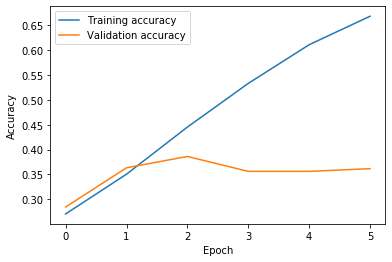

In [43]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig("evolacc1.png")
plt.show()

pred = model.predict_classes(test_pad)

assert pred.shape == (2210,)

filename = "logreg_lstm_y_test_sst.txt"
np.savetxt(filename, pred.astype(int), fmt="%u")

## 4.3 - innovate !

In [50]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout

embed_dim  = 64  # word embedding dimension
nhid       = 16  # number of hidden units in the LSTM
vocab_size = 5000  # size of the vocabulary
n_classes  = 5

dropout_rate = 0.7

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(Conv1D(32,5,activation='relu'))
model.add(Dropout(dropout_rate))
model.add(MaxPooling1D(2,2))
model.add(Conv1D(16,3,activation='relu'))
model.add(Dropout(dropout_rate))
model.add(MaxPooling1D(2,2))
model.add(LSTM(nhid, dropout=0.45, recurrent_dropout=0.45,return_sequences=False))
model.add(Dense(n_classes, activation='sigmoid'))


loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

bs = 64
n_epochs = 14

history = model.fit(train_pad, train_classes, batch_size=bs, epochs=n_epochs, validation_data=(dev_pad, dev_classes))

pred = model.predict_classes(test_pad)

filename = "logreg_1dconv_y_test_sst.txt"
np.savetxt(filename, pred.astype(int), fmt="%u")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 32)          10272     
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 16)          1552      
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 16)          0         
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, None, 16)         